In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, solve_triangular, cholesky
from copy import deepcopy

GP regression by Kalman filtering

In [2]:
ell = 0.1
sigma_2 = 0.1**2
mag_sigma_2 = 1**2
N = 10 # number of random points!
M = 500 # number of test points!
lambda_v = np.sqrt(3)/ell
F = np.hstack([[0, 1], [-lambda_v**2, -2*lambda_v]]).reshape(2,2)
L = np.hstack([0, 1]).reshape(2, 1)
Q = 4 * lambda_v**3 * mag_sigma_2
H = np.hstack([1, 0]).reshape(1, 2)
P_inf = mag_sigma_2 * np.diag([1, lambda_v**2])

In [7]:
to = np.sort(np.random.rand(N), axis=-1).reshape(N,1)
tf = np.linspace(0, 1, M).reshape(M, 1)
totf = np.vstack([to, tf])
indices = np.argsort(totf.flatten(), axis=-1)
totf = totf[indices]
TT = totf.shape[0]

In [8]:
yo = to**2 - np.sin(4 * to)*2 + 5.2 + np.random.randn(N,1) * np.sqrt(sigma_2)

In [22]:
# The GP model @ fixed hyperparameters

toto_g = np.tile(to, [1, N]) - np.tile(to.T, [N, 1]) # as grids!
totf_g = np.tile(to, [1, M]) - np.tile(tf.T, [N, 1])
tftf_g = np.tile(tf, [1, M]) - np.tile(tf.T, [M, 1])
print(toto_g.shape, totf_g.shape, tftf_g.shape)
Kxx = mag_sigma_2 * (1 + np.sqrt(3) * np.abs(toto_g)/ell) * \
                np.exp(- np.sqrt(3)*np.abs(toto_g)/ell)
Kxp = mag_sigma_2 * (1 + np.sqrt(3) * np.abs(totf_g)/ell) * \
                np.exp(- np.sqrt(3)*np.abs(totf_g)/ell)
Kxpxp = mag_sigma_2 * (1 + np.sqrt(3) * np.abs(tftf_g)/ell) * \
                np.exp(- np.sqrt(3)*np.abs(tftf_g)/ell)

def gp_calcs(Kxx, Kxp, Kxpxp, yo, sigma_2):
    Lxx = cholesky(Kxx + np.eye(yo.shape[0])*sigma_2, lower=True) # stabilise?
    E = solve_triangular(Lxx, Kxp, lower=True)
    v = solve_triangular(Lxx, yo, lower=True)
    mu = E.T @ v
    cov = Kxpxp - E.T @ E
    print (E.shape)
    return mu, cov

mu_gp, cov_gp = gp_calcs(Kxx, Kxp, Kxpxp, yo, sigma_2)

(10, 10) (10, 500) (500, 500)
(10, 500)


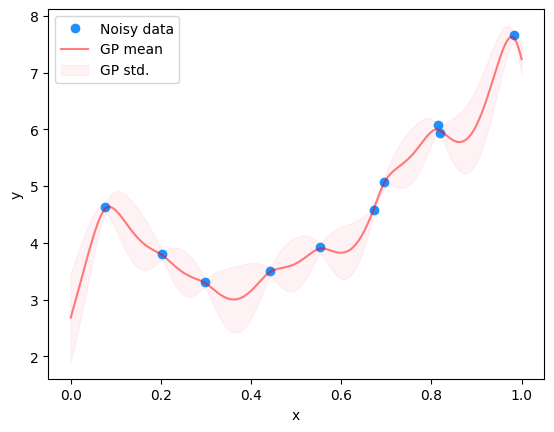

In [21]:
mu_gp = mu_gp.flatten()
var_gp = np.diag(cov_gp).flatten()

plt.plot(to, yo, 'o', color='dodgerblue',  label='Noisy data')
plt.plot(tf, mu_gp, 'r-', label='GP mean', alpha=0.5)
plt.fill_between(tf.flatten(), mu_gp+np.sqrt(var_gp), \
                 mu_gp-np.sqrt(var_gp), color='pink', alpha=0.2, label='GP std.')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [12]:
doupdate = indices < N

In [13]:
## Setup initial mean 
m = np.zeros((2, 1))
P = deepcopy(P_inf)


MF = np.zeros((2, TT))
PF = np.zeros((2, 2, TT))
MP = np.zeros((2, TT))
PP = np.zeros((2, 2, TT))
GS = np.zeros((2, 2, TT))

for k in range(0, TT):
    if k == 0:
        dt = 0
    else:
        dt = totf[k] - totf[k-1]
    
    # Solving the linear time invariant SDE here!
    A = expm(F * dt)
    Q = P_inf - A @ P_inf @ A.T
    
    # Kalman prediction
    mp = A @ m
    Pp = A @ P @ A.T + Q
    
    # Pre-calculate smoother gain
    Gs =  np.linalg.lstsq(Pp.T, (P @ A.T).T)[0].T
    
    # Kalman update
    if doupdate[k]:
        v = float(yo[indices[k]] - H @ m)
        S = H @ P @ H.T + sigma_2
        K = np.linalg.lstsq(S.T, (P @ H.T).T)[0].T
        m += K * v
        P -= K @ H @ P
    else:
        m = mp
        P = Pp
    
    MF[:, k] = m.T
    PF[:, :, k] = P
    MP[:,k] = mp.T
    PP[:,:,k] = Pp
    GS[:,:,k] = Gs
    
# Run the RTS smoother!
MS = deepcopy(MF)
PS = deepcopy(PF)
ms = MS[:,-1]
Ps = PS[:,:,-1]
for j in range(TT-2, -1, -1):
    ms = MF[:,j] + GS[:,:,j+1] @ (ms - MP[:,j+1])
    Ps = PF[:,:,j] + GS[:,:,j+1] @ (Ps - PP[:,:,j+1]) @ (GS[:,:,j+1]).T
    MS[:,j] = ms
    PS[:,:,j] = Ps

/tmp/ipykernel_5459/3804693476.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Gs =  np.linalg.lstsq(Pp.T, (P @ A.T).T)[0].T
/tmp/ipykernel_5459/3804693476.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  v = float(yo[indices[k]] - H @ m)
/tmp/ipykernel_5459/3804693476.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  K = np.linalg.l

In [14]:
def get_var_f(index):
    var_f_ = []
    for j in range(0, len(index)):
        if index[j]:
            var_f_.append( H @ PF[:,:,j] @ H.T )
    return np.array(var_f_)

def get_var_smooth(index):
    var_s_ = []
    for j in range(0, len(index)):
        if index[j]:
            var_s_.append( H @ PS[:,:,j] @ H.T )
    return np.array(var_s_)

In [15]:
# Extract values!
m_f = (H @ MF).T
m_s = (H @ MS).T

In [16]:
# Only the test inputs!
ii = [indices > N-1][0]
m_f = m_f[ii].flatten()
m_s = m_s[ii].flatten()
var_f = get_var_f(ii).flatten()
var_s = get_var_smooth(ii).flatten()

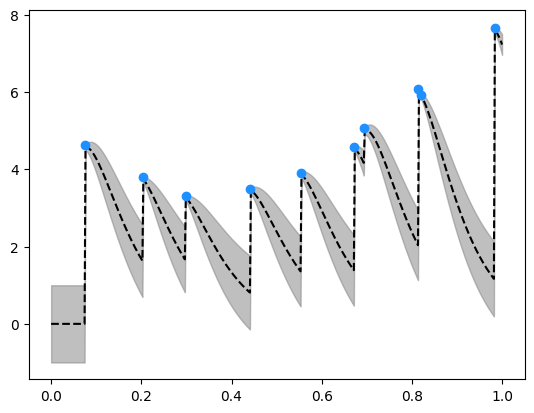

In [17]:
plt.plot(tf, m_f, 'k--')
plt.plot(to, yo, 'o', color='dodgerblue')
plt.fill_between(tf.flatten(), m_f-np.sqrt(var_f), \
                 m_f+np.sqrt(var_f), color='gray', alpha=0.5)

plt.show()

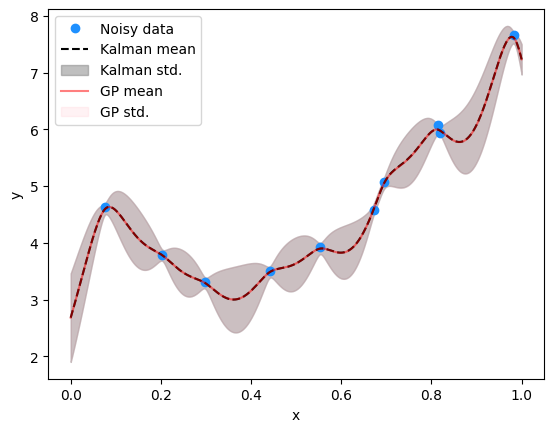

In [18]:
plt.plot(to, yo, 'o', color='dodgerblue',  label='Noisy data')
plt.plot(tf, m_s, 'k--', label='Kalman mean')
plt.fill_between(tf.flatten(), m_s+np.sqrt(var_s), \
                 m_s-np.sqrt(var_s), color='gray', alpha=0.5, label='Kalman std.')
mu_gp = mu_gp.flatten()
var_gp = np.diag(cov_gp).flatten()

plt.plot(tf, mu_gp, 'r-', label='GP mean', alpha=0.5)
plt.fill_between(tf.flatten(), mu_gp+np.sqrt(var_gp), \
                 mu_gp-np.sqrt(var_gp), color='pink', alpha=0.2, label='GP std.')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [19]:
var_gp - var_s

array([ 4.84280939e-06,  4.91648673e-06,  4.98372038e-06,  5.04377751e-06,
        5.09589454e-06,  5.13927944e-06,  5.17311480e-06,  5.19656164e-06,
        5.20876423e-06,  5.20885589e-06,  5.19596610e-06,  5.16922887e-06,
        5.12779275e-06,  5.07083256e-06,  4.99756309e-06,  4.90725510e-06,
        4.79925375e-06,  4.67299990e-06,  4.52805462e-06,  4.36412713e-06,
        4.18110683e-06,  3.97909973e-06,  3.75846978e-06,  3.51988580e-06,
        3.26437450e-06,  2.99338043e-06,  2.70883344e-06,  2.41322471e-06,
        2.10969209e-06,  1.80211596e-06,  1.49522654e-06,  1.19472414e-06,
        9.07413476e-07,  6.41353768e-07,  4.06026140e-07,  2.12520235e-07,
        7.37420230e-08,  4.64499483e-09,  2.24867416e-08,  1.46734244e-07,
        3.97257162e-07,  7.93180167e-07,  1.35265616e-06,  2.09268791e-06,
        3.02897029e-06,  4.17575020e-06,  5.54570153e-06,  7.14981283e-06,
        8.99728579e-06,  1.10954426e-05,  1.34496409e-05,  1.60631948e-05,
        1.89373012e-05,  